# Apple or Tomato? Binary Image Classification

In this project, we will make a binary classification model that can identify whether it is an apple or a tomato in the image. 

Apples and tomatoes share some common characteristics such as the round shape or the red color. 

It might be a tricky work to train a model properly, so that it can differntiate the two different obejcts. Let's begin!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%cd /content/drive/MyDrive/딥러닝/archive-3

/content/drive/MyDrive/딥러닝/archive-3


In [11]:
# Core
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Upload Data

> We will first define the paths where train and test images are located at. Just copy the path to each of the directories. 

In [12]:
train_dir = '/content/drive/MyDrive/딥러닝/archive-3/train'
test_dir = '/content/drive/MyDrive/딥러닝/archive-3/test'

## Data Augmentation

> Here, we will use ImageDataGenerator which is for image preprocessing. One for the train data, another for the test data. 

With ImageDataGenerator we can also augment our image dataset. Through this process, we can have more dataset to train the model. We can, for example, shift an image or zoom it to create new images. 

However, it is very important to only augment the train dataset. Augmenting the test dataset equals manipulating the true information. 

In [31]:
train_data_generator = ImageDataGenerator(
        # We use 'validation_split' to divide train dataset into train and validation dataset. 
        # validation dataset ratio is 0.15 and the rest is for the training.
        validation_split=0.15,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        preprocessing_function=preprocess_input,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [32]:
# Hyperparameters
CFG = dict(
    seed = 55,
    batch_size = 16,
    img_size = (299,299),
    epochs = 20,
    patience = 10
)

In [33]:
# Connect generators to data in folders
train_generator = train_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=True, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="training")
validation_generator = train_data_generator.flow_from_directory(train_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'], subset="validation")
test_generator = test_data_generator.flow_from_directory(test_dir, target_size=CFG['img_size'], shuffle=False, seed=CFG['seed'], class_mode='categorical', batch_size=CFG['batch_size'])

# Number of samples and classes
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes:'+str(classes))

Found 251 images belonging to 2 classes.
Found 43 images belonging to 2 classes.
Found 97 images belonging to 2 classes.
Classes:['apples', 'tomatoes']


In [55]:
train_generator.class_indices

{'apples': 0, 'tomatoes': 1}

In [65]:
import collections

a = train_generator.classes.tolist()
counter = collections.Counter(a)

counter

Counter({0: 140, 1: 111})

Our train dataset is more or less balanced.

Lets check some images.

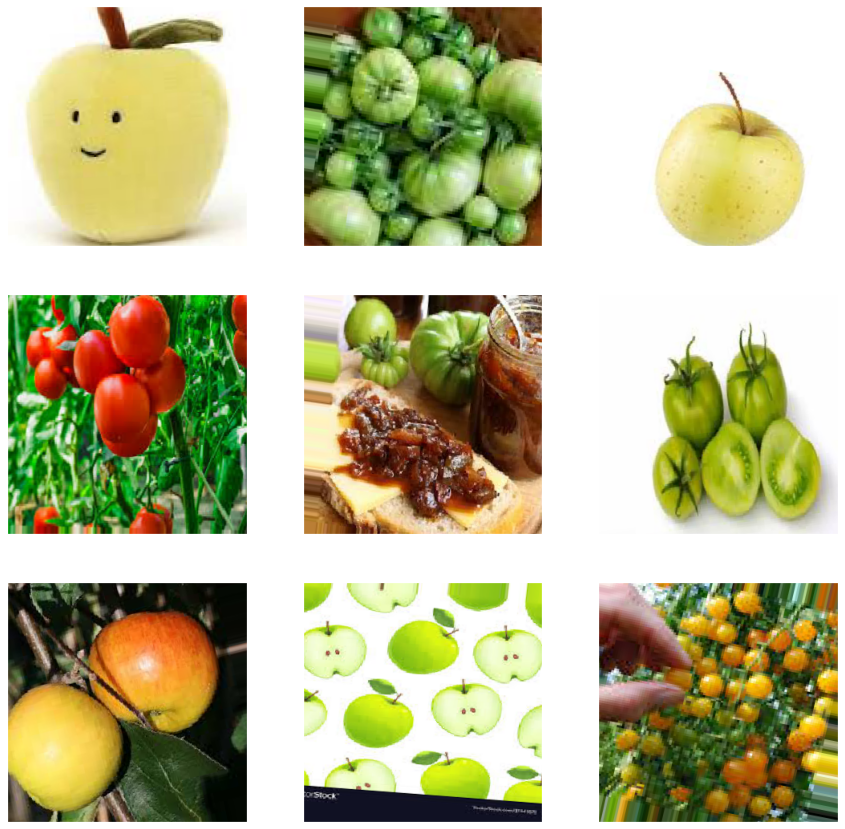

In [40]:
# Visualise some examples
plt.figure(figsize=(15,15))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    ax.grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    batch = (train_generator.next()[0] + 1) * 127.5
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

## Transfer Learning

We will use a prtrained model which is InceptionResNetV2. 

To fit our dataset into the model, we need to remove the last layer with 'include_top=False'.
**********

1. Define the base model (pretrained model)

    1.1 weights : imagenet is a very huge image database, we bring a model that has been trained by the imagenet. 

    1.2 include_top: use False, to change the last layer(s) of neural network. 

    1.3 input_shape: Define the input shape of the dastaset. Since we have color image, this means 3 dimensional. Here it will be 299*299*3.

2. Add new layers to the base model 

    2.1 bring the base model and define the output as x. 

    2.2 make the dimension of the output flat. 

    2.3 add a new dense layer with 100 neurons and activation function - relu. 

    2.4 define the last layer. Output neurons must be the number of classes we would like to predict. 

3. Create a model instance. 

4. Define optimizer for the model.

5. compile.


In [44]:
# Pre-trained deep convolutional neural network
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(CFG['img_size'][0], CFG['img_size'][1], 3))

# Add new layers
x = base_model.output
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
predictions = Dense(2, activation='sigmoid', kernel_initializer='random_uniform')(x)

# Build model
model = Model(inputs=base_model.input, outputs=predictions)
    

> Why freezing layers in pre-trained model improves model performance?



In [ ]:
# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [45]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [47]:
# Define optimiser
optimizer = Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',f1_m,recall_m,precision_m])

## Train Model

We will now train our model for our image dataset.

Since we need a best model, decide how we will define our best model. Here, we will define our best model based on the validation loss. The best model will be automatically saved.

Early stopping can reduce excessive time. If there is no chance of further improvement, the training process will be stopped.
- patience: Number of epochs with no improvement after which training will be stopped.

In [48]:
# Save the best model
save_checkpoint = keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=CFG['patience'], verbose=True)

In [49]:
# Train model
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // CFG['batch_size'],
        epochs=CFG['epochs'],
        callbacks=[save_checkpoint,early_stopping],
        validation_data=validation_generator,
        verbose=True,
        validation_steps=nb_validation_samples // CFG['batch_size'])

Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 2.1586 - accuracy: 0.7021 - f1_m: 0.6674 - recall_m: 0.6254 - precision_m: 0.7342
Epoch 1: val_loss improved from inf to 0.38693, saving model to model.h5
15/15 [==============================] - 154s 9s/step - loss: 2.1586 - accuracy: 0.7021 - f1_m: 0.6674 - recall_m: 0.6254 - precision_m: 0.7342 - val_loss: 0.3869 - val_accuracy: 0.7500 - val_f1_m: 0.7278 - val_recall_m: 0.7188 - val_precision_m: 0.7375
Epoch 2/20
15/15 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.8085 - f1_m: 0.7886 - recall_m: 0.7754 - precision_m: 0.8032
Epoch 2: val_loss improved from 0.38693 to 0.33946, saving model to model.h5
15/15 [==============================] - 128s 9s/step - loss: 0.3917 - accuracy: 0.8085 - f1_m: 0.7886 - recall_m: 0.7754 - precision_m: 0.8032 - val_loss: 0.3395 - val_accuracy: 0.7812 - val_f1_m: 0.6881 - val_recall_m: 0.6250 - val_precision_m: 0.7679
Epoch 3/20
15/15 [========================

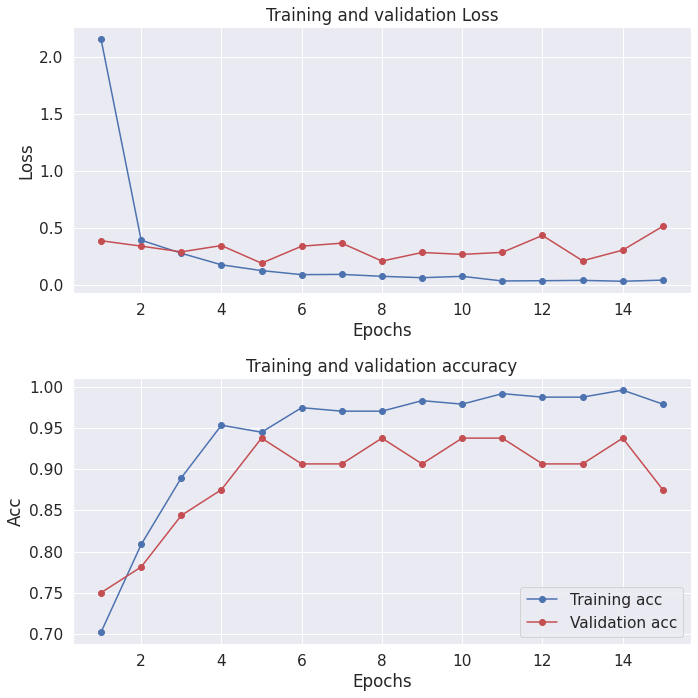

In [50]:
# History
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# Loss
epochs_x = range(1, len(loss_values) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_values, 'b-o', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'r-o', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy
plt.subplot(2,1,2)
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, acc_values, 'b-o', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'r-o', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
# Evaluate on validation dataset
score = model.evaluate(validation_generator, verbose=False)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.595369279384613
Val accuracy: 0.8372092843055725


In [52]:
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3123764991760254
Test accuracy: 0.9175257682800293


7/7 [==============================] - 49s 6s/step


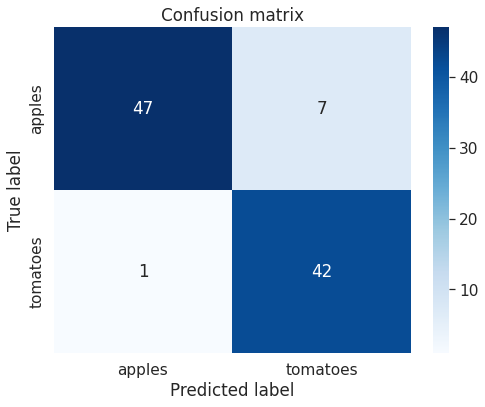

In [53]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

reference: https://www.kaggle.com/code/samuelcortinhas/transfer-learning-with-tensorflow